In [1]:
import numpy as np
import torch

import sys
sys.path.insert(1,"../scripts")
from get_voxels import get_mol_voxels
from networks import Encoder, UNet3D, EncoderCNN, DecoderRNN, UNet3D_tcond, UNet3D_ptcond
from utils import scale_model_input

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import itertools
from diffusers import DDPMScheduler


vocab_list = ["pad", "start", "end",
    "C", "c", "N", "n", "S", "s", "P", "O", "o",
    "B", "F", "I",
    "Cl", "[nH]", "Br", # "X", "Y", "Z",
    "1", "2", "3", "4", "5", "6",
    "#", "=", "-", "(", ")"  # Misc
]

vocab_i2c_v1 = {i: x for i, x in enumerate(vocab_list)}
vocab_c2i_v1 = {vocab_i2c_v1[i]: i for i in vocab_i2c_v1}

device = "cuda"
net = UNet3D_ptcond(in_channels=5, num_classes=5)
net.load_state_dict(torch.load("../models/net_pharm_weights_180558.pkl"))
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

#Load Encoding and Captioning Networks (from Ligdream)
encoderCNN = EncoderCNN(5)
# encoderCNN.load_state_dict(torch.load("../models/encoder-210000.pkl",map_location="cpu"))
encoderCNN.load_state_dict(torch.load("../models/encoderCNN_pharm_weights_180558.pkl",map_location="cpu"))

decoder = DecoderRNN(512, 1024, 29, 1)
# decoder.load_state_dict(torch.load("../models/decoder-210000.pkl", map_location='cpu'))
decoder.load_state_dict(torch.load("../models/decoderRNN_pharm_weights_180558.pkl",map_location="cpu"))

use_cuda = True

net.to(device)
encoderCNN.to(device)
decoder.to(device)

def gen_mols(smiles, gen_num = 1, timesteps = 50, get_vox=True, vox2vox=False, strength=None):
    '''Input smiles, uses denoising u-net to generate representation then decodes.
    If vox2vox enabled then puts in a noised version of the original voxel'''
    x_ref, y = get_mol_voxels(smiles)

    if not vox2vox and strength != None:
        print(print("Strength ignored if generating from random noise."))
        strength=0
    elif not vox2vox:
        strength=0

    ddpm.set_timesteps(timesteps)

    if vox2vox:
        assert strength != None, f"Strength must be set for vox2vox"
        assert strength >=0 and strength <=1, f"Strength must be set for vox2vox"
        x = x_ref.reshape(-1,5,24,24,24).to(device)
        x = torch.cat([x]*gen_num)
        noise = torch.rand(x.shape).to(device)
        x = ddpm.add_noise(x, noise, timesteps=ddpm.timesteps[np.int64(np.ceil(timesteps*strength))])
    else:
        x = torch.randn(gen_num, 5, 24,24,24).to(device)

    
    y = y.reshape(-1,3,24,24,24)
    y = torch.cat([y]*x.shape[0]).to(device)

    ddpm.set_timesteps(timesteps)

    # Sampling loop
    for i, t in enumerate(ddpm.timesteps):

        # Get model pred
        with torch.no_grad():
            residual = net(x, torch.cat([t.expand(1)]*x.shape[0]).to(device), y.to(device))  
        # Update sample with step
        x = ddpm.step(residual, t, x).prev_sample

    noise_pred = residual.detach()

    embedding = encoderCNN(noise_pred)
    captions = torch.stack(decoder.sample(embedding)).T.cpu().detach().numpy()
    smiles_gen = []
    for predict in captions:
        csmile = ""
        for xchar in predict[0:]:
            if xchar == 1:
                continue
            if xchar == 2:
                break
            csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
        smiles_gen.append(csmile)

    # smiles_gen = np.unique(np.array(smiles_gen))

    if get_vox:
        return noise_pred.cpu(), smiles_gen, x_ref.cpu()
    else:
        return smiles_gen     

/home/chris/miniconda3/envs/diff_dream/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-09 16:07:01,497 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-05-09 16:07:01,498 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [16]:
input_smiles = "O=S(C(C=C1)=CC=C1OC2=CC=C(Cl)C=C2)(C3(CCOCC3)C(NO)=O)=O"
pred, smiles_gen, x_ref = gen_mols(input_smiles, 64, timesteps=50, vox2vox=True, strength=0.9)

# input_smiles = "COC(=O)CN(C)C(=O)c1cccnc1Cl"
# gen_smiles = []
# while len(gen_smiles) < 512:
#     pred, smiles_gen, x_ref = gen_mols(input_smiles, 64, timesteps=50, vox2vox=True, strength=0.6)
#     gen_smiles += list(smiles_gen)

# gen_smiles = np.unique(np.array(gen_smiles))

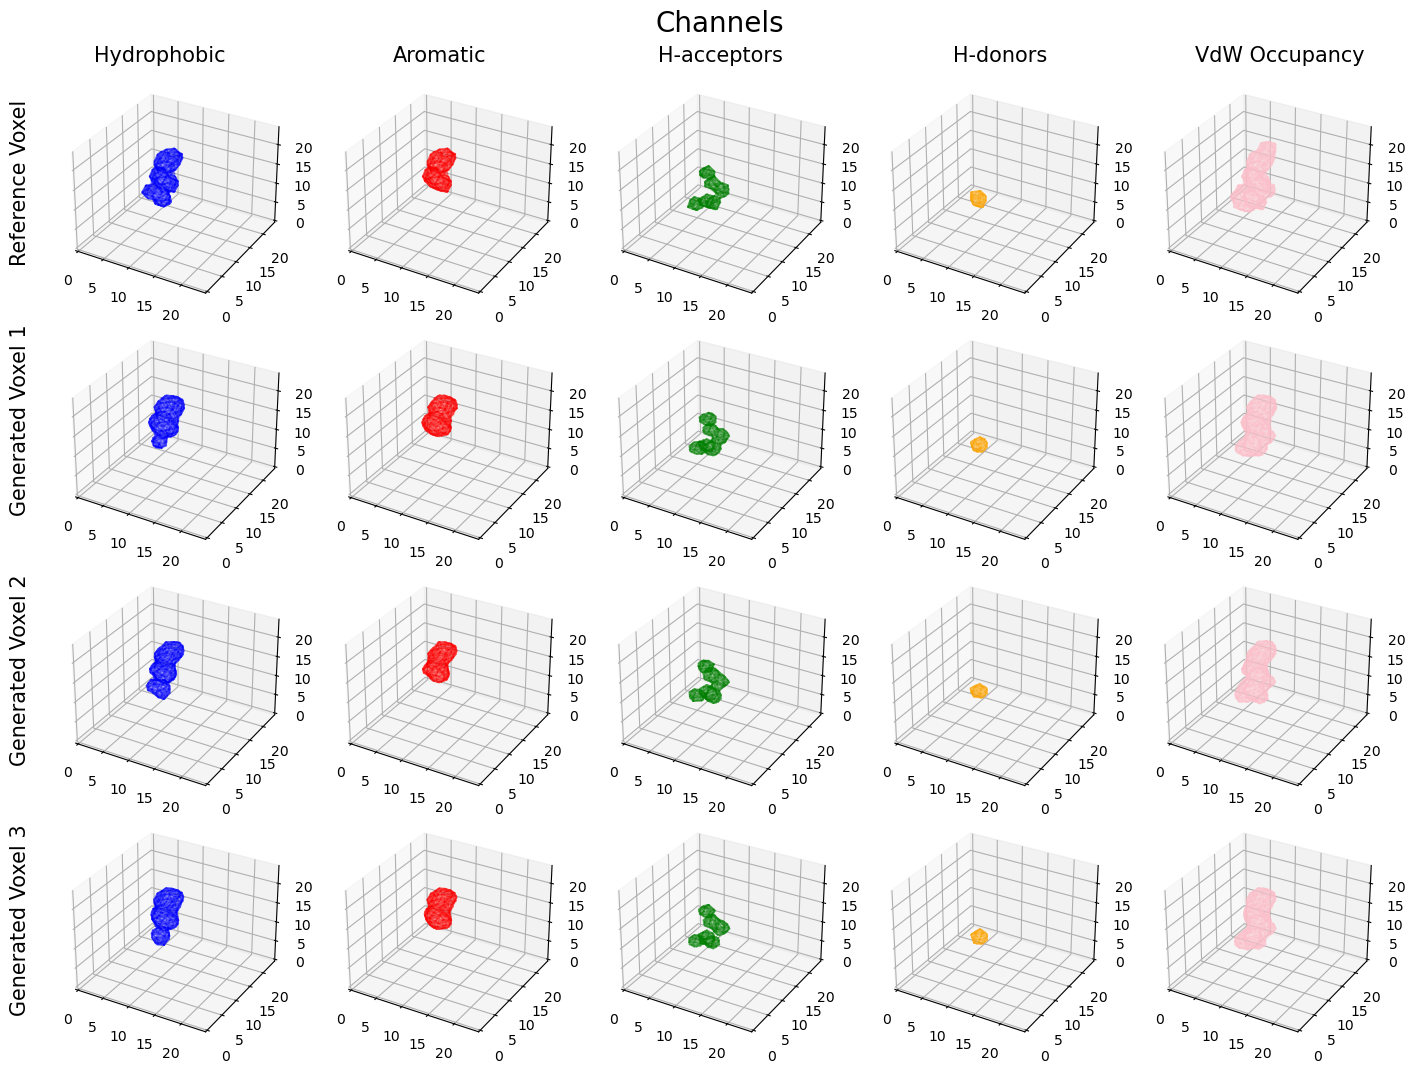

In [17]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D


colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(14,10))

for i in range(5):
    ax = fig.add_subplot(4,5,i+1, projection='3d')
    data = x_ref[i].detach().numpy()
    try:
        threshold = 0.8
        verts, faces= measure.marching_cubes_classic(data, threshold)
        mesh = Poly3DCollection(verts[faces], alpha=0.2, color=colors[i])
        ax.add_collection3d(mesh)
        ax.set_xlim(0, 24)
        ax.set_ylim(0, 24)
        ax.set_zlim(0, 24)
    except:
        mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
        ax.add_collection3d(mesh)
        continue

k = 6
for j in range(3):
    for i in range(5):
        ax = fig.add_subplot(4,5,k, projection='3d')
        data = pred[j][i].detach().numpy()
        try:

            threshold = 0.6
            verts, faces= measure.marching_cubes_classic(data, threshold)

            mesh = Poly3DCollection(verts[faces], alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
            ax.set_xlim(0, 24)
            ax.set_ylim(0, 24)
            ax.set_zlim(0, 24)
            k += 1
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
            k += 1
            continue

fig.text(0,0.8,"Reference Voxel", fontsize=15, rotation=90, ha = "center")
fig.text(0,0.55,"Generated Voxel 1", fontsize=15, rotation=90, ha = "center")
fig.text(0,0.3,"Generated Voxel 2", fontsize=15, rotation=90, ha = "center")
fig.text(0,0.05,"Generated Voxel 3", fontsize=15, rotation=90, ha = "center")

fig.text(0.1,1,"Hydrophobic", fontsize=15,ha = "center")
fig.text(0.3,1,"Aromatic", fontsize=15, ha = "center")
fig.text(0.5,1,"H-acceptors", fontsize=15, ha = "center")
fig.text(0.7,1,"H-donors", fontsize=15, ha = "center")
fig.text(0.9,1,"VdW Occupancy", fontsize=15, ha = "center")
fig.text(0.5,1.03,"Channels", fontsize=20, ha = "center")


fig.tight_layout()
plt.show()

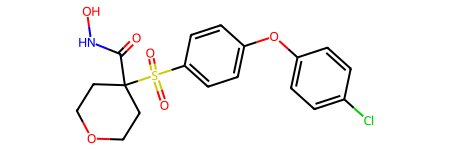

In [18]:
from rdkit import Chem

Chem.MolFromSmiles(input_smiles)

Text(0.5, 1.0, 'TPSA')

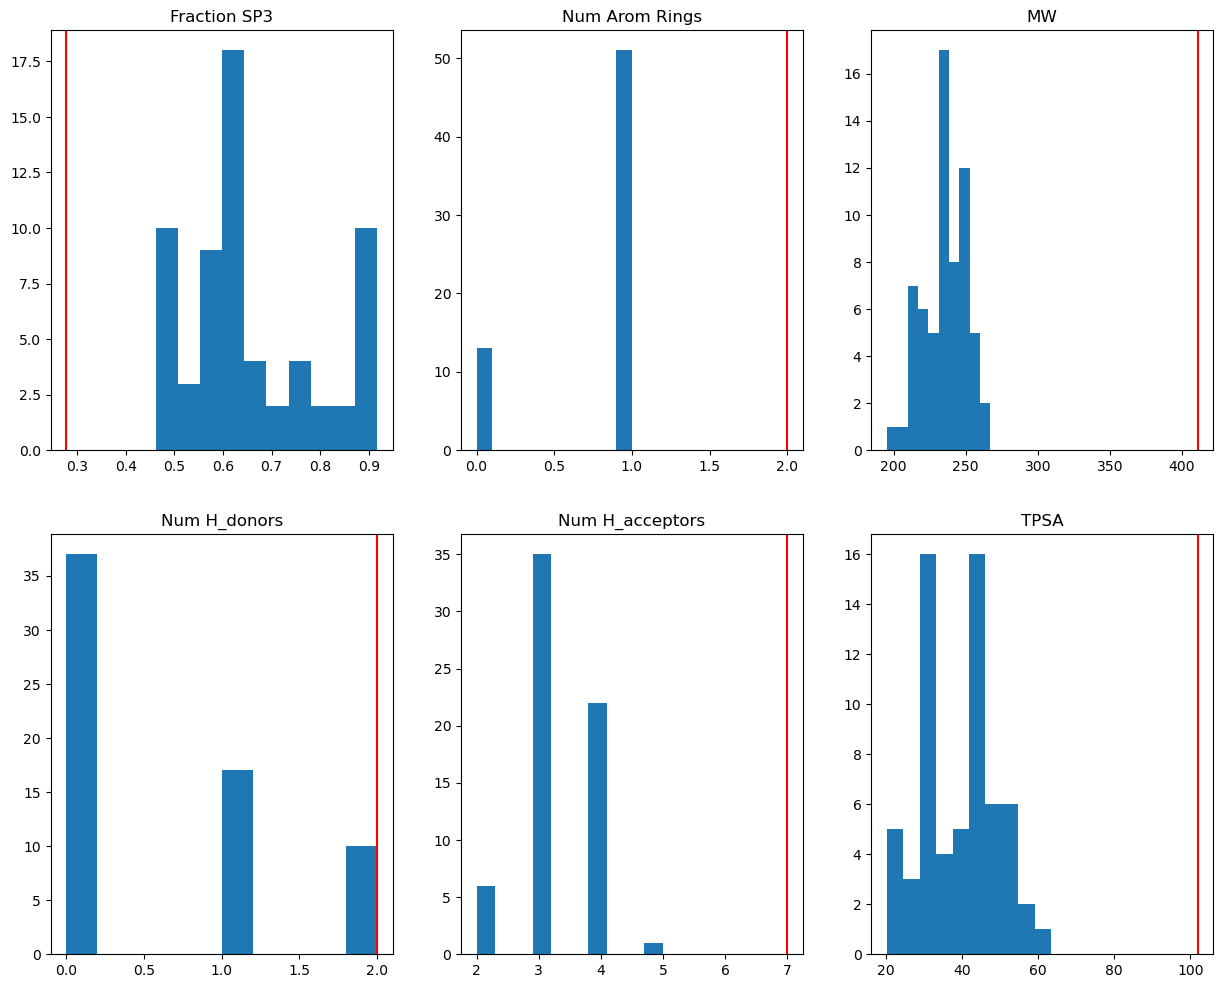

In [19]:
import pandas as pd

ref_mol = Chem.MolFromSmiles(input_smiles)

predictions = pd.DataFrame(smiles_gen, columns=["SMILES"])
predictions["mol"] = [Chem.MolFromSmiles(x) for x  in predictions.SMILES]
predictions.dropna(inplace=True)
predictions["mw"] = [Chem.rdMolDescriptors.CalcExactMolWt(mol) for mol in predictions.mol]
predictions["tpsa"] = [Chem.rdMolDescriptors.CalcTPSA(mol) for mol in predictions.mol]
predictions["sp3"]=[Chem.rdMolDescriptors.CalcFractionCSP3(mol) for mol in predictions.mol]
predictions["n_arings"]=[Chem.rdMolDescriptors.CalcNumAromaticRings(mol) for mol in predictions.mol]
predictions["h_don"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBD(mol) for mol in predictions.mol]
predictions["h_acc"] = [Chem.rdMolDescriptors.CalcNumLipinskiHBA(mol) for mol in predictions.mol]
similarity = []

ref_fp = Chem.AllChem.GetMorganFingerprintAsBitVect(ref_mol,2,nBits=2048)
for mol in predictions.mol:
    fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)
    similarity.append(Chem.AllChem.DataStructs.FingerprintSimilarity(ref_fp,fp))

predictions["similarity"] = similarity

fig, axs = plt.subplots(2,3,figsize=(15,12))

axs[0,0].hist(predictions.sp3)
axs[0,0].axvline(Chem.rdMolDescriptors.CalcFractionCSP3(ref_mol),0,1, color="red")
axs[0,0].set_title("Fraction SP3")
axs[0,1].hist(predictions.n_arings)
axs[0,1].axvline(Chem.rdMolDescriptors.CalcNumAromaticRings(ref_mol),0,1, color="red")
axs[0,1].set_title("Num Arom Rings")
axs[0,2].hist(predictions.mw)
axs[0,2].axvline(Chem.rdMolDescriptors.CalcExactMolWt(ref_mol),0,1, color="red")
axs[0,2].set_title("MW")
axs[1,0].hist(predictions.h_don)
axs[1,0].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBD(ref_mol),0,1, color="red")
axs[1,0].set_title("Num H_donors")
axs[1,1].hist(predictions.h_acc)
axs[1,1].axvline(Chem.rdMolDescriptors.CalcNumLipinskiHBA(ref_mol),0,1, color="red")
axs[1,1].set_title("Num H_acceptors")
axs[1,2].hist(predictions.tpsa)
axs[1,2].axvline(Chem.rdMolDescriptors.CalcTPSA(ref_mol),0,1, color="red")
axs[1,2].set_title("TPSA")

/home/chris/miniconda3/envs/diff_dream/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


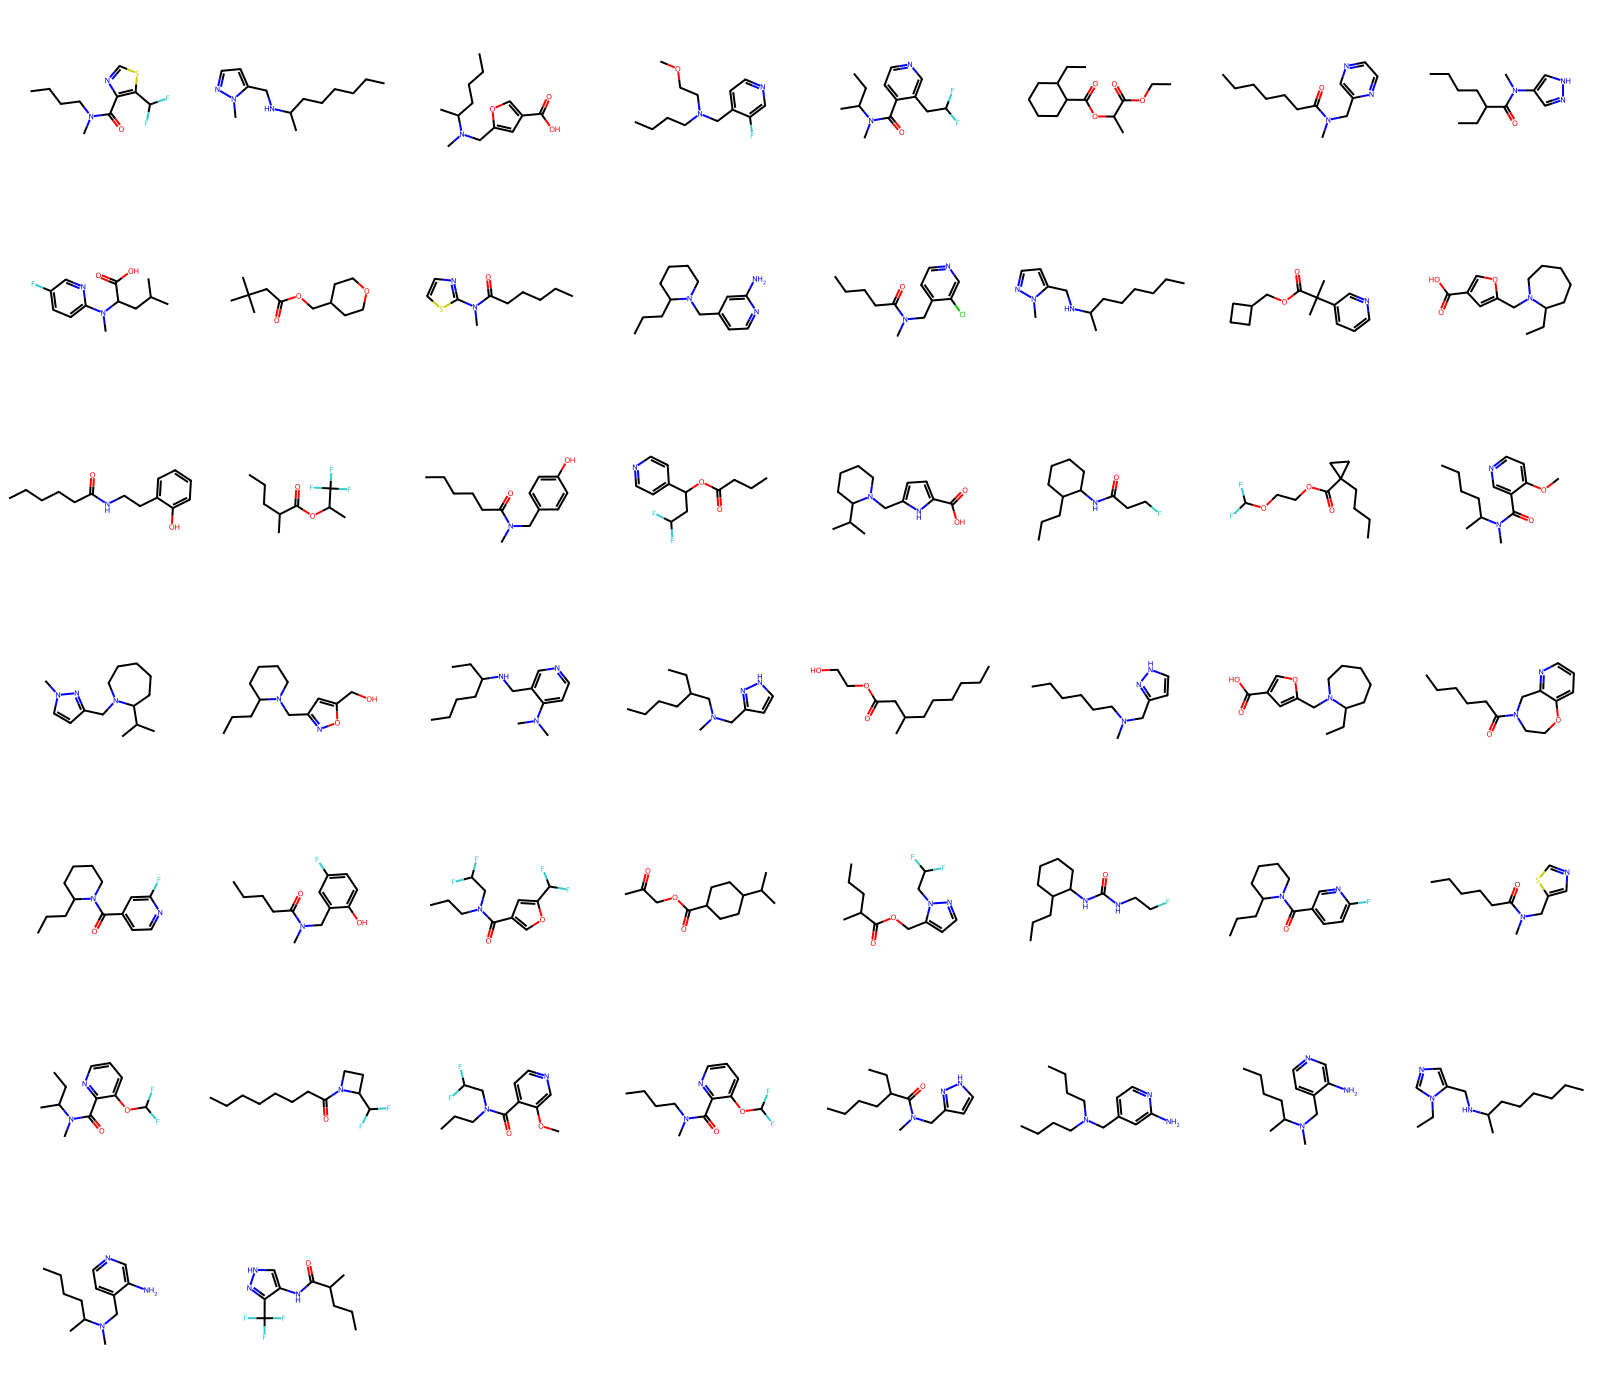

In [20]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in np.array(smiles_gen)],molsPerRow=8)

In [21]:
predictions.sort_values("similarity", ascending=False).index[:8]

Int64Index([9, 55, 60, 36, 31, 54, 59, 12], dtype='int64')

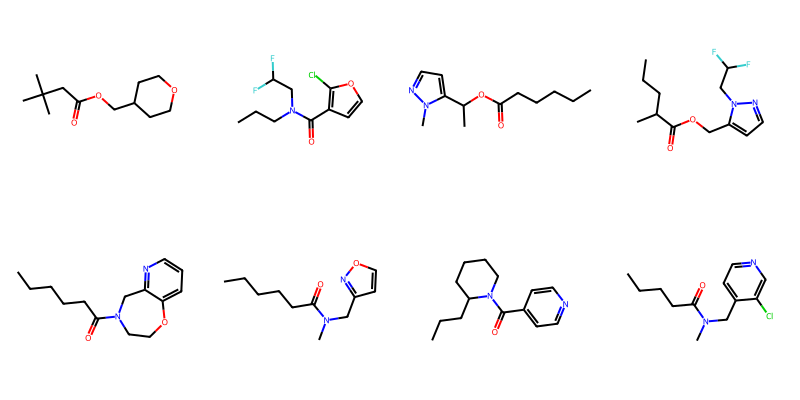

In [22]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in np.array(smiles_gen)[predictions.sort_values("similarity", ascending=False).index[:8]]],molsPerRow=4)

In [40]:
input_smiles = "CCC(CC)CN1C=CC=C1C=CC=CC(N)=O"

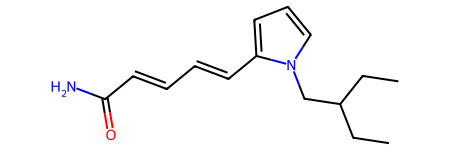

In [41]:
Chem.MolFromSmiles(input_smiles)

tensor(0.0049)


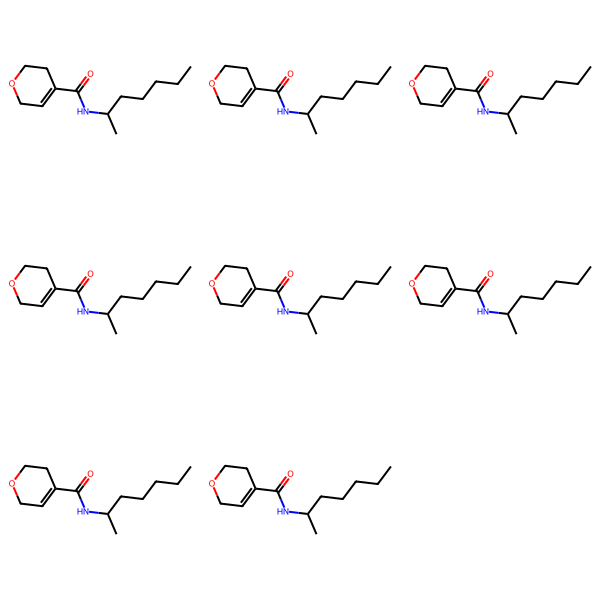

In [47]:
from rdkit.Chem import Draw
input_smiles
x_ref, y = get_mol_voxels(input_smiles)
ddpm.set_timesteps(1000)
noise = torch.randn(x_ref.shape)
x_ref = ddpm.add_noise(x_ref, noise, ddpm.timesteps[900:901])
print(x_ref.mean())
ref_con = net(torch.stack([x_ref]*8).cuda(), torch.cat([ddpm.timesteps[900:901]]*8).cuda(), torch.stack([y]*8).cuda())
embedding = encoderCNN(ref_con)

captions = torch.stack(decoder.sample(embedding)).T

gen_smiles = []
for sample in captions:
    csmile = ""
    for xchar in sample[0:]:
        if xchar == 1:
            continue
        if xchar == 2:
            break
        csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
    gen_smiles.append(csmile)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in gen_smiles])

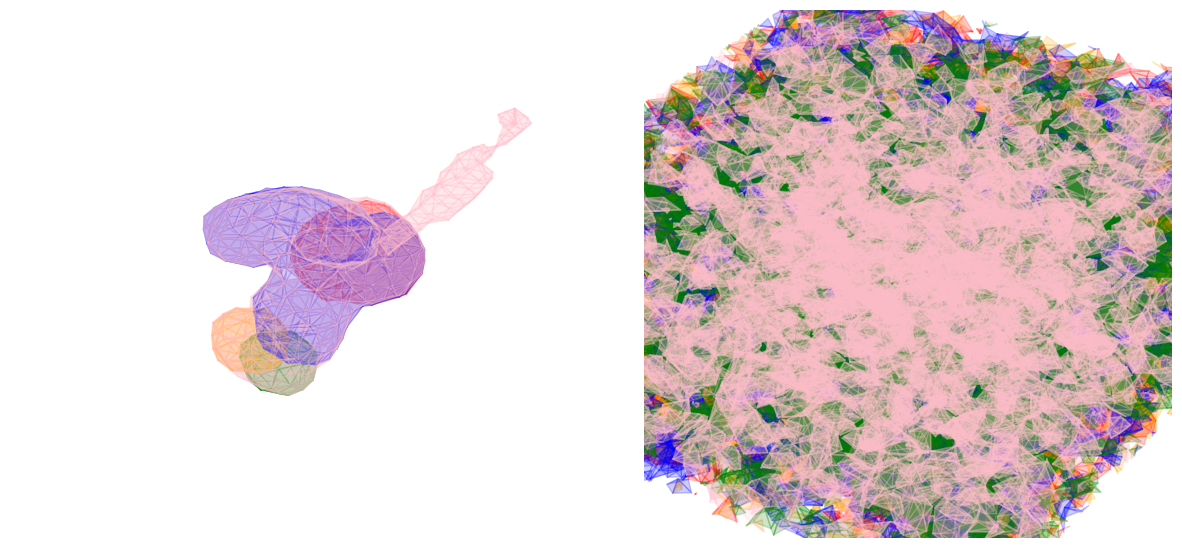

In [49]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal

from rdkit.Chem import Draw

colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1,2,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = ref_con[0][i].cpu().detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.2, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)

ax = fig.add_subplot(1,2,2, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i].detach().numpy()
    threshold = 0.2
    try:
        verts, faces= measure.marching_cubes_classic(data, threshold)
        mesh = Poly3DCollection(verts[faces], alpha=0.2, color=colors[i])
        ax.add_collection3d(mesh)
    except:
        mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
        ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)

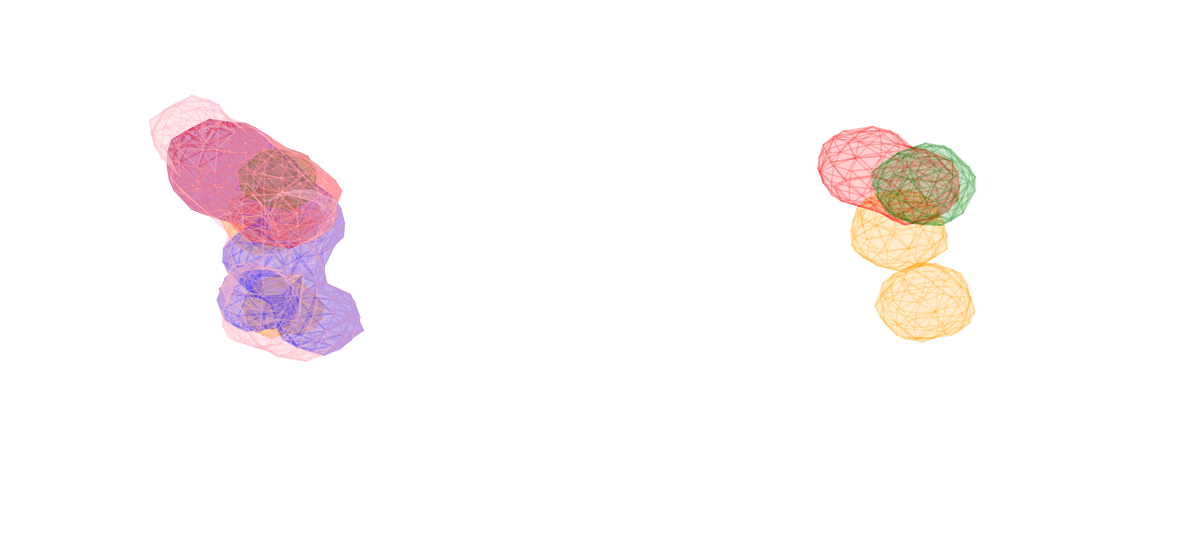

In [191]:
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal

from rdkit.Chem import Draw

x_ref, y = get_mol_voxels("ClC1=CC=C2C(N=CC=C2N[C@@H](CCCN(CC)CC)C)=C1")

colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1,2,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i].detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.2, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)

ax = fig.add_subplot(1,2,2, projection='3d')
ax._axis3don = False


colors = ["red","green","orange"]

for i in range(3):
    data = y[i].detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)

# Evaluate from same x_ref

In [2]:
input_smiles = "COC(=O)CN(C)C(=O)c1cccnc1Cl"
x_ref, y1 = get_mol_voxels(input_smiles)

def generate_molecule_with_refs(x_ref, y1, gen_num = 1, timesteps = 50, get_vox=True, vox2vox=False, strength=None):

    '''Input smiles, uses denoising u-net to generate representation then decodes.
    If vox2vox enabled then puts in a noised version of the original voxel'''

    if not vox2vox and strength != None:
        print(print("Strength ignored if generating from random noise."))
        strength=0
    elif not vox2vox:
        strength=0

    ddpm.set_timesteps(timesteps)

    if vox2vox:
        assert strength != None, f"Strength must be set for vox2vox"
        assert strength >=0 and strength <=1, f"Strength must be set for vox2vox"
        x = x_ref.reshape(-1,5,24,24,24).to(device)
        x = torch.cat([x]*gen_num)
        noise = torch.rand(x.shape).to(device)
        x = ddpm.add_noise(x, noise, timesteps=ddpm.timesteps[np.int64(np.ceil(timesteps*strength))])
    else:
        x = torch.randn(gen_num, 5, 24,24,24).to(device)

    
    y = y1.reshape(-1,3,24,24,24)
    y = torch.cat([y]*x.shape[0]).to(device)

    ddpm.set_timesteps(timesteps)

    # Sampling loop
    for i, t in enumerate(ddpm.timesteps):

        # Get model pred
        with torch.no_grad():
            residual = net(x, torch.cat([t.expand(1)]*x.shape[0]).to(device), y.to(device))  
        # Update sample with step
        x = ddpm.step(residual, t, x).prev_sample

    noise_pred = residual.cpu().detach()

    smiles_gen = []
    for predict in noise_pred:
        embedding = encoderCNN(predict.reshape(-1,5,24,24,24))

        captions = decoder.sample(embedding)
        captions = [captions]

        gen_smiles = []
        for sample in captions:
            csmile = ""
            for xchar in sample[0:]:
                if xchar == 1:
                    continue
                if xchar == 2:
                    break
                csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
            gen_smiles.append(csmile)

        smiles_gen = smiles_gen+gen_smiles

    smiles_gen = np.unique(np.array(smiles_gen))
    if get_vox:
        return noise_pred.cpu(), smiles_gen, x_ref.cpu()
    else:
        return smiles_gen    

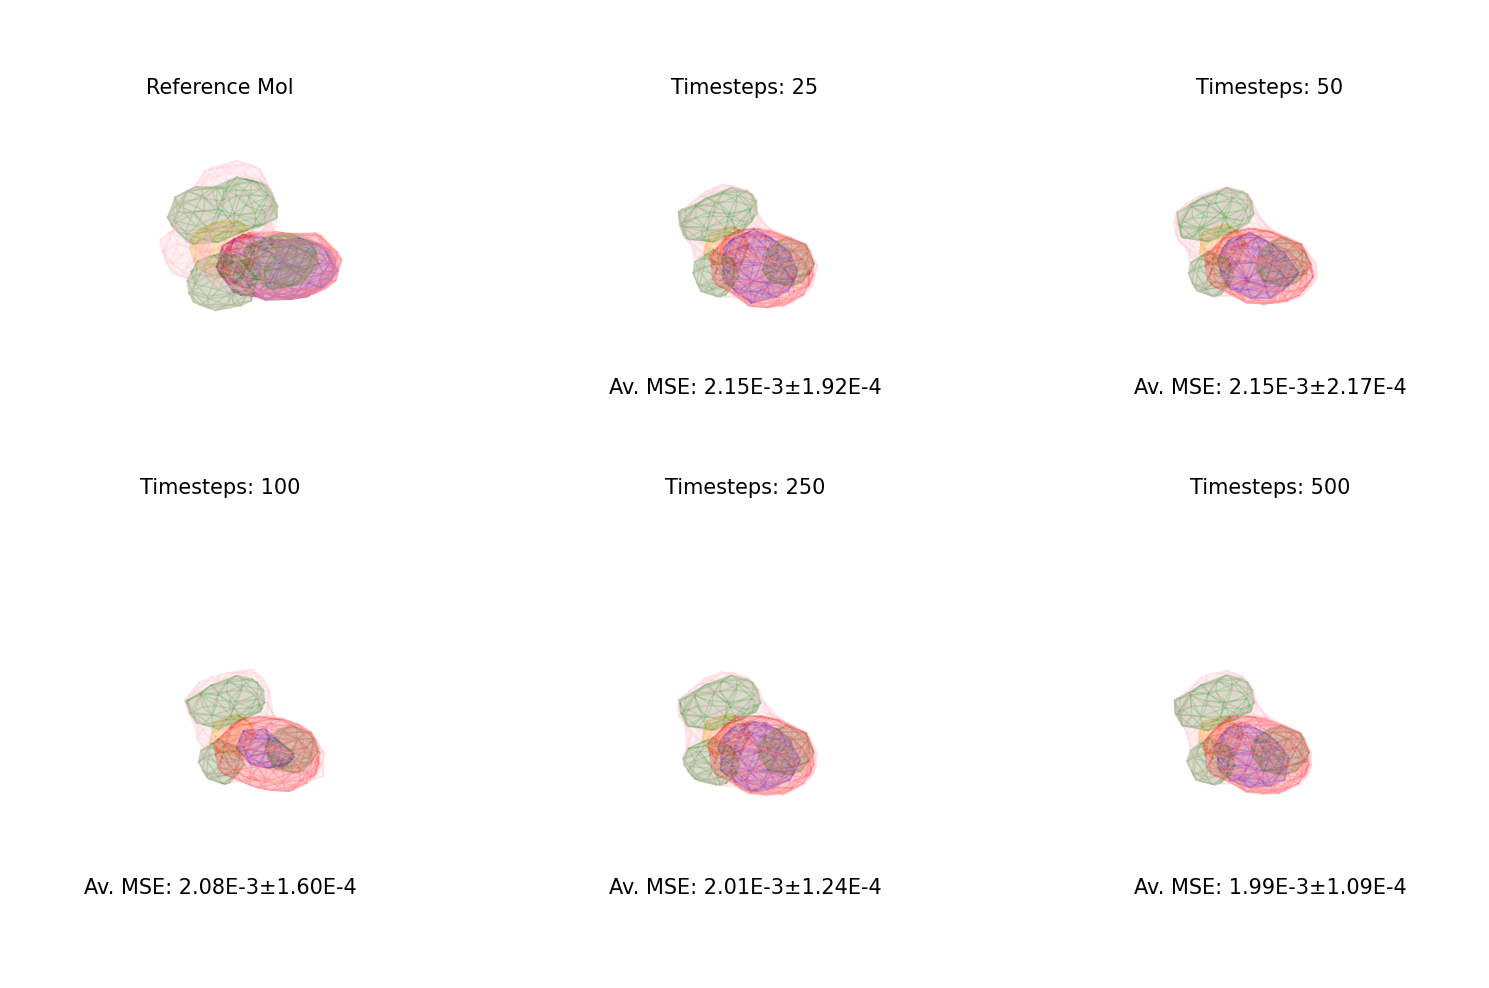

In [3]:
x_refs = []
closest_reps = []
timesteps = [25,50,100,250,500]
av_mse = []
stdev = []
for ts in timesteps:
    pred, smiles_gen, x_ref= generate_molecule_with_refs(x_ref, y1,64,timesteps=ts,vox2vox=False)
    x_refs += [x_ref.detach().numpy()]
    mses = []
    for rep in pred:
        mses.append(torch.nn.functional.mse_loss(x_ref,rep).detach().item())
    av_mse.append(np.mean(mses))
    stdev.append(np.std(mses))
    closest_reps.append(pred[np.argmin(mses)])

import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal



colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i].detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)


for j in range(5):
    ax = fig.add_subplot(2,3,j+2, projection='3d')
    ax._axis3don = False

    for i in range(5):
        try:
            data = closest_reps[j][i].detach().numpy()
            threshold = 0.5
            verts, faces= measure.marching_cubes_classic(data, threshold)


            mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
            ax.add_collection3d(mesh)
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
        ax.set_xlim(4, 20)
        ax.set_ylim(4, 20)
        ax.set_zlim(4, 20)


fig.text(0.15,0.9,"Reference Mol", fontsize=15,ha = "center") 
fig.text(0.5,0.9,"Timesteps: 25", fontsize=15, ha = "center")
fig.text(0.85,0.9,"Timesteps: 50", fontsize=15, ha = "center")
fig.text(0.15,0.5,"Timesteps: 100", fontsize=15,ha = "center") 
fig.text(0.5,0.5,"Timesteps: 250", fontsize=15, ha = "center")
fig.text(0.85,0.5,"Timesteps: 500", fontsize=15, ha = "center")

fig.text(0.5,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[0]),Decimal(stdev[0])), fontsize=15,ha = "center") 
fig.text(0.85,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[1]),Decimal(stdev[1])), fontsize=15, ha = "center")
fig.text(0.15,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[2]),Decimal(stdev[2])), fontsize=15,ha = "center") 
fig.text(0.5,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[3]),Decimal(stdev[3])), fontsize=15, ha = "center")
fig.text(0.85,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[4]),Decimal(stdev[4])), fontsize=15, ha = "center")


fig.tight_layout()
plt.show()


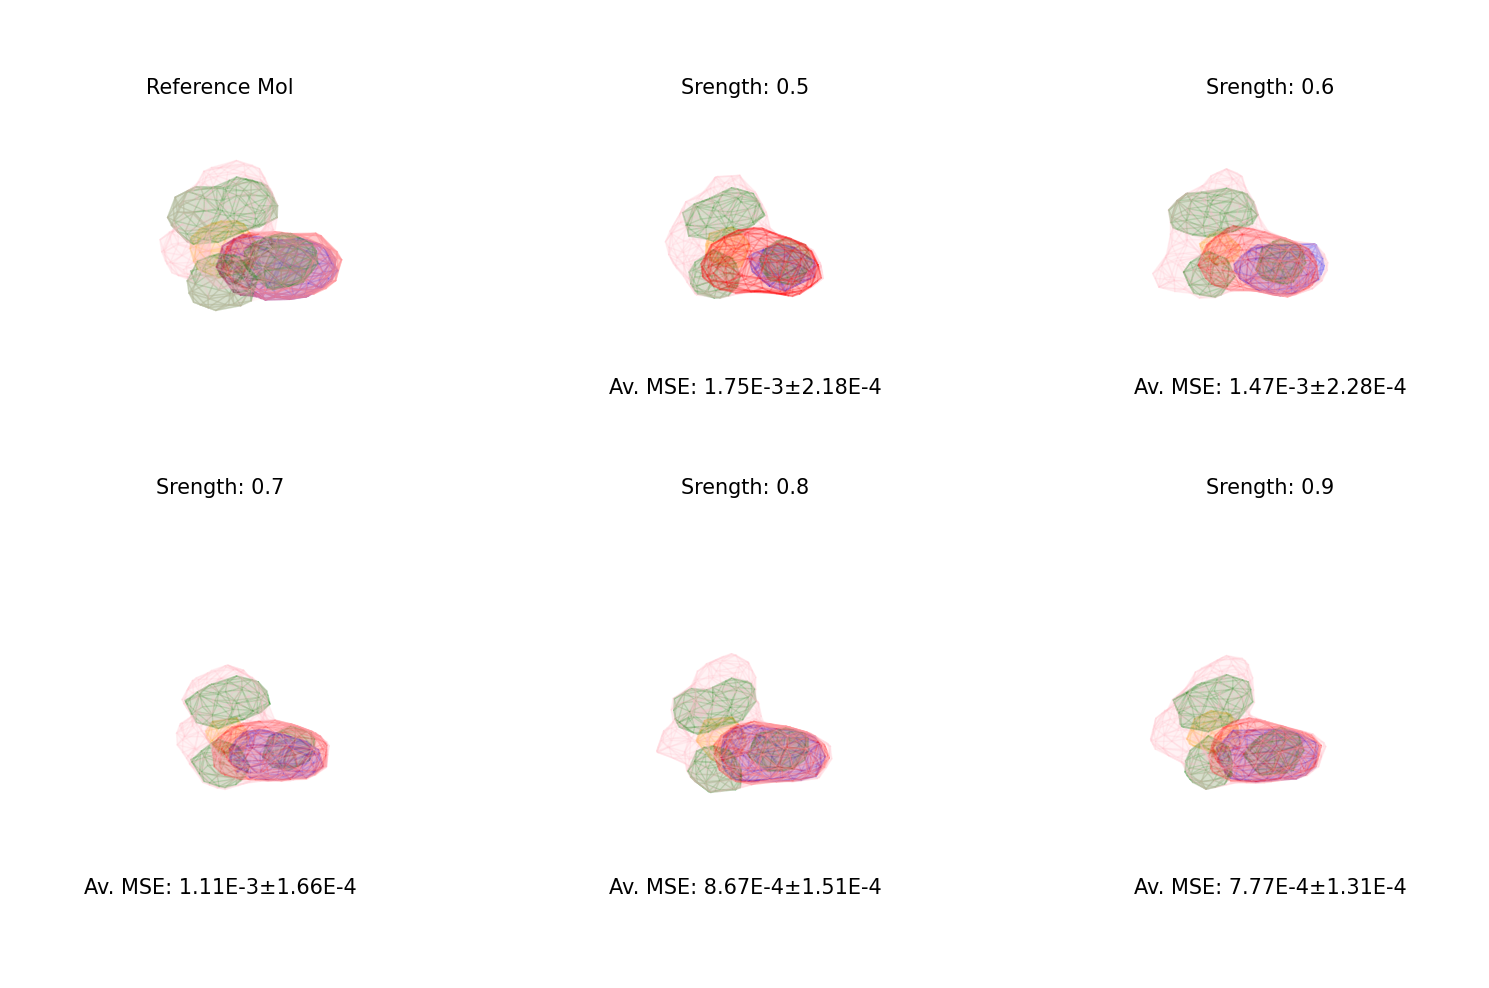

In [4]:
x_refs = []
closest_reps = []
strengths = [0.5,0.6,0.7,0.8,0.9]
av_mse = []
stdev = []
for st in strengths:
    pred, smiles_gen, x_ref= generate_molecule_with_refs(x_ref, y1,64,timesteps=50,vox2vox=True, strength=st)
    x_refs += [x_ref.detach().numpy()]
    mses = []
    for rep in pred:
        mses.append(torch.nn.functional.mse_loss(x_ref,rep).detach().item())
    av_mse.append(np.mean(mses))
    stdev.append(np.std(mses))
    closest_reps.append(pred[np.argmin(mses)])

import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from decimal import Decimal



colors = ["blue","red","green","orange","pink"]
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2,3,1, projection='3d')
ax._axis3don = False

for i in range(5):
    data = x_ref[i].detach().numpy()
    threshold = 0.2
    verts, faces= measure.marching_cubes_classic(data, threshold)
    mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
    ax.add_collection3d(mesh)
    ax.set_xlim(4, 20)
    ax.set_ylim(4, 20)
    ax.set_zlim(4, 20)


for j in range(5):
    ax = fig.add_subplot(2,3,j+2, projection='3d')
    ax._axis3don = False

    for i in range(5):
        try:
            data = closest_reps[j][i].detach().numpy()
            threshold = 0.5
            verts, faces= measure.marching_cubes_classic(data, threshold)


            mesh = Poly3DCollection(verts[faces], alpha=0.1, color=colors[i])
            ax.add_collection3d(mesh)
        except:
            mesh = Poly3DCollection(np.random.normal(0,0.01,verts[faces].shape), alpha=0.2, color=colors[i])
            ax.add_collection3d(mesh)
        ax.set_xlim(4, 20)
        ax.set_ylim(4, 20)
        ax.set_zlim(4, 20)


fig.text(0.15,0.9,"Reference Mol", fontsize=15,ha = "center") 
fig.text(0.5,0.9,"Srength: 0.5", fontsize=15, ha = "center")
fig.text(0.85,0.9,"Srength: 0.6", fontsize=15, ha = "center")
fig.text(0.15,0.5,"Srength: 0.7", fontsize=15,ha = "center") 
fig.text(0.5,0.5,"Srength: 0.8", fontsize=15, ha = "center")
fig.text(0.85,0.5,"Srength: 0.9", fontsize=15, ha = "center")

fig.text(0.5,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[0]),Decimal(stdev[0])), fontsize=15,ha = "center") 
fig.text(0.85,0.6,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[1]),Decimal(stdev[1])), fontsize=15, ha = "center")
fig.text(0.15,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[2]),Decimal(stdev[2])), fontsize=15,ha = "center") 
fig.text(0.5,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[3]),Decimal(stdev[3])), fontsize=15, ha = "center")
fig.text(0.85,0.1,"Av. MSE: {:.2E}±{:.2E}".format(Decimal(av_mse[4]),Decimal(stdev[4])), fontsize=15, ha = "center")


fig.tight_layout()
plt.show()


In [1]:
with open("../reports/log.txt","r") as f:
    log = f.readlines()

In [4]:
net_loss = []
enc_loss = []
cap_loss = []

for line in log:
    if line.find("Net Loss") != -1:
        net_loss += [float(line.split(":")[-1][:-1])]
    if line.find("Encoder Loss") != -1:
        enc_loss += [float(line.split(":")[-1][:-2])]
    if line.find("Captioning Loss") != -1:
        cap_loss += [float(line.split(":")[-1][:-2])]

Text(0, 0.5, 'BCE_loss')

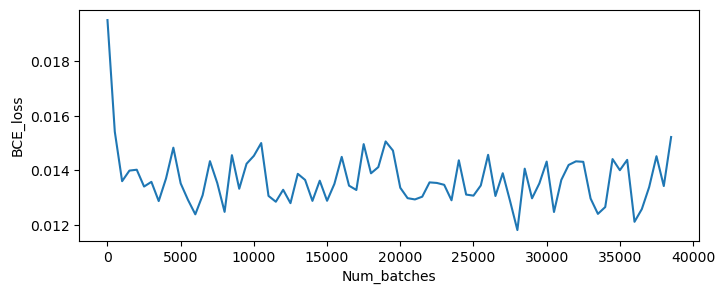

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(np.arange(len(net_loss))*500, net_loss)
ax.set_xlabel("Num_batches")
ax.set_ylabel("BCE_loss")

Text(0, 0.5, 'BCE_loss')

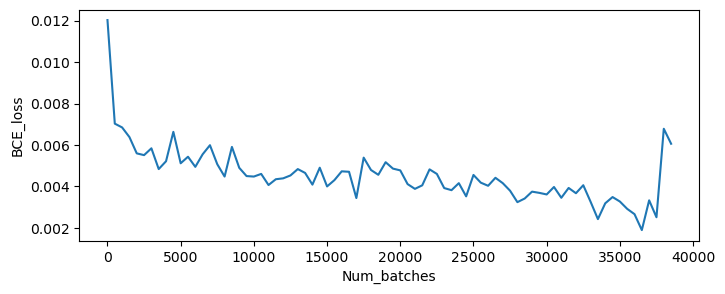

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(np.arange(len(enc_loss))*500, enc_loss)
ax.set_xlabel("Num_batches")
ax.set_ylabel("BCE_loss")

Text(0, 0.5, 'captioning_loss')

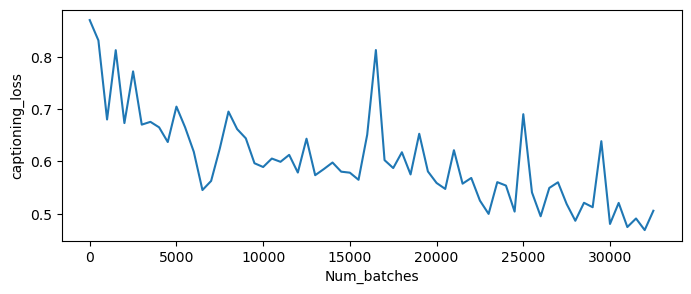

In [54]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(np.arange(len(cap_loss))*500, cap_loss)
ax.set_xlabel("Num_batches")
ax.set_ylabel("captioning_loss")

Text(0, 0.5, 'captioning_loss')

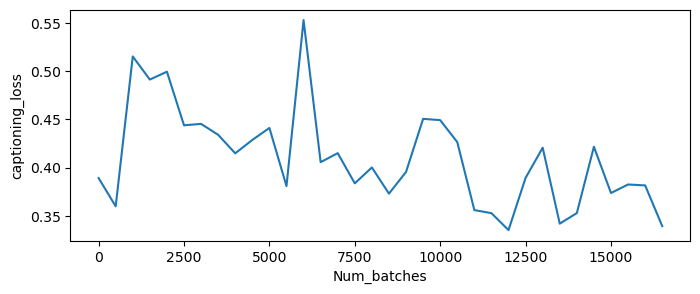

In [ ]:
with open("../reports/log_cap.txt","r") as f:
    log = f.readlines()

cap_loss = []

for line in log:
    if line.find("Captioning Loss") != -1:
        cap_loss += [float(line.split(":")[-1][:-2])]

fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(np.arange(len(cap_loss))*500, cap_loss)
ax.set_xlabel("Num_batches")
ax.set_ylabel("captioning_loss")

Text(0, 0.5, 'captioning_loss')

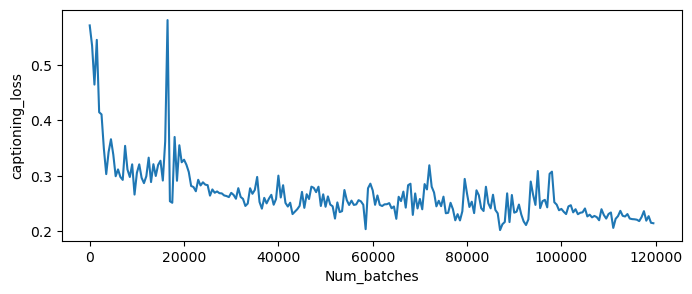

In [72]:
with open("../reports/log_cap2.txt","r") as f:
    log = f.readlines()

cap_loss = []

for line in log:
    if line.find("Captioning Loss") != -1:
        cap_loss += [float(line.split(":")[-1][:-2])]

fig, ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(np.arange(len(cap_loss))*500, cap_loss)
ax.set_xlabel("Num_batches")
ax.set_ylabel("captioning_loss")